In [1]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.utils.data as data_utils
from devinterp.optim.sgld import SGLD
from devinterp.optim.sgnht import SGNHT

from joblib import Parallel, delayed

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

PRIMARY, SECONDARY, TERTIARY = sns.color_palette("muted")[:3]
PRIMARY_LIGHT, SECONDARY_LIGHT, TERTIARY_LIGHT = sns.color_palette("pastel")[:3]
def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    train_loss = 0
    for data, target in (train_loader):
        optimizer.zero_grad()
        output = model(data.to(DEVICE))
        loss = criterion(output, target.to(DEVICE))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss / len(train_loader)


def evaluate(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            loss = criterion(output, target.to(DEVICE))
            test_loss += loss.item()
    return test_loss / len(test_loader)


# Define the neural network
class Net(nn.Module):
    def __init__(
        self,
        hidden_layer_sizes=[1024, 1024],
        input_dim=28 * 28,
        output_dim=10,
        activation=F.relu,
        with_bias=True,
    ):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.layer_sizes = [input_dim] + hidden_layer_sizes + [output_dim]
        self.activation = activation
        self.with_bias = with_bias
        self.layers = nn.ModuleList()
        for i in range(len(self.layer_sizes) - 1):
            dim_in, dim_out = self.layer_sizes[i : i + 2]
            self.layers.append(nn.Linear(dim_in, dim_out, bias=self.with_bias).float())

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x
# DEVICE = "cuda"
# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
print(len(train_data))
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
# Initialize model, loss, optimizer and sgld sampler
model = Net().to(DEVICE)
criterion = nn.CrossEntropyLoss()
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
n_epochs = 40
from devinterp.slt import estimate_learning_coeff

# Load MNIST data
batch_size = 512
train_data = datasets.MNIST("../data", train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# Load test data
test_data = datasets.MNIST("../data", train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

rlct_estimates_sgnht = []
rlct_estimates_sgld = []

def rlct_estimate(model, train_loader, criterion):
    rlct_estimate_sgnht = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            diffusion_factor=0.01,
            num_samples=len(train_data),
        ),
        sampling_method=SGNHT,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
        verbose=False,
    )
    rlct_estimate_sgld = estimate_learning_coeff(
        model,
        train_loader,
        criterion=criterion,
        optimizer_kwargs=dict(
            lr=1e-5,
            noise_level=1.0,
            elasticity=100.0,
            num_samples=len(train_data),
            temperature="adaptive",
        ),
        sampling_method=SGLD,
        num_chains=1,
        num_draws=400,
        num_burnin_steps=0,
        num_steps_bw_draws=1,
        device=DEVICE,
        verbose=False,
    )
    print(rlct_estimate_sgld, rlct_estimate_sgnht)
    return rlct_estimate_sgnht, rlct_estimate_sgld
from tqdm import tqdm

def train_model_size(hidden_layer_size, n_epochs=20, lr=0.005, verbose=False):
    train_loss_trajectories = []
    test_loss_trajectories = []
    model = Net(hidden_layer_sizes=hidden_layer_size).to(DEVICE)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    
    if verbose:
        loop = tqdm(range(n_epochs))
    else:
        loop = range(n_epochs)
    
    for _ in loop:
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
        test_loss = evaluate(model, test_loader, criterion)
        train_loss_trajectories.append(train_loss)
        test_loss_trajectories.append(test_loss)
        # print(f"Model size {hidden_layer_size} Epoch {epoch+1}, Train Loss: {train_loss}, Test Loss: {test_loss}")
    return copy.deepcopy(model), train_loss_trajectories, test_loss_trajectories

def plot_chains(hyperparams, rlct_estimate_summary_list, task_name):
    args_list = make_args_list(**hyperparams)
    for rlct_estimate_summary, args in zip(rlct_estimate_summary_list, args_list):
        # make label out of args
        label = ""
        for key, value in args.items():
            if key == "optimizer":
                label += f"{value.__name__}, "
            else:
                label += f"{key}: {value}, "
        print(label)
        trace = rlct_estimate_summary['trace']
        for chain, df in trace.groupby("chain"):
            plt.plot(df["step"], df["loss"], label= f"{label} Chain {chain}")
    plt.xlabel("Step")
    plt.ylabel(r"$L_n(w)$")
    plt.legend()
    plt.gcf().set_size_inches(16, 8)
    plt.title(f"Task {task_name}")

100%|██████████| 9912422/9912422 [00:00<00:00, 11640774.03it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 6617990.27it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 5458844.04it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 25366882.51it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

60000


### Expts begin

100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


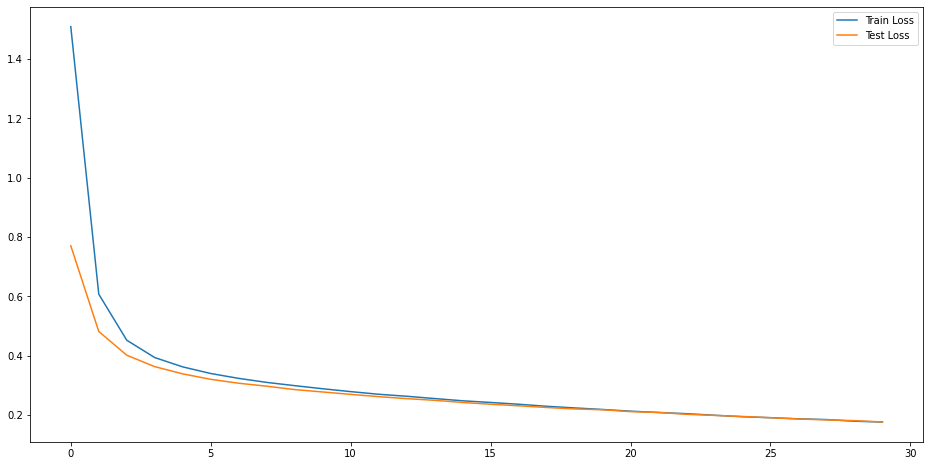

In [2]:
hidden_size = [1024]
torch.manual_seed(0)
model, train_losses, test_losses = train_model_size(hidden_size, n_epochs=30, lr=0.005, verbose=True)

plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.gcf().set_size_inches(16, 8)
plt.show()

### Compare without changing the criterion

In [3]:
task1_lablels = [8]
task2_lablels = [2]
task1_str = "detect 8"
task2_str = "detect 2"

In [4]:
indices = [idx for idx, target in enumerate(train_data.targets) if target in task1_lablels]
task1_train_loader = torch.utils.data.DataLoader(data_utils.Subset(train_data, indices),
                                         batch_size=batch_size, shuffle=True)

In [5]:
indices = [idx for idx, target in enumerate(train_data.targets) if target in task2_lablels]
task2_train_loader = torch.utils.data.DataLoader(data_utils.Subset(train_data, indices),
                                         batch_size=batch_size, shuffle=True)

In [6]:
# check accuracy on task 1 and task 2
def check_accuracy(model, test_loader, task_name):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(DEVICE))
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.to(DEVICE).view_as(pred)).sum().item()
    print(f"Task {task_name} Accuracy: {correct / len(test_loader.dataset)}")

check_accuracy(model, task1_train_loader, task1_str)
check_accuracy(model, task2_train_loader, task2_str)

Task detect 8 Accuracy: 0.9348829259955563
Task detect 2 Accuracy: 0.9415911379657603


Task 1

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    3.4s


lr: 1e-06, SGLD, noise_level: 4.0, elasticity: 1.0, temperature: adaptive, num_draws: 160, num_samples: 5851, restrict_to_orth_grad: True, num_chains: 1, 


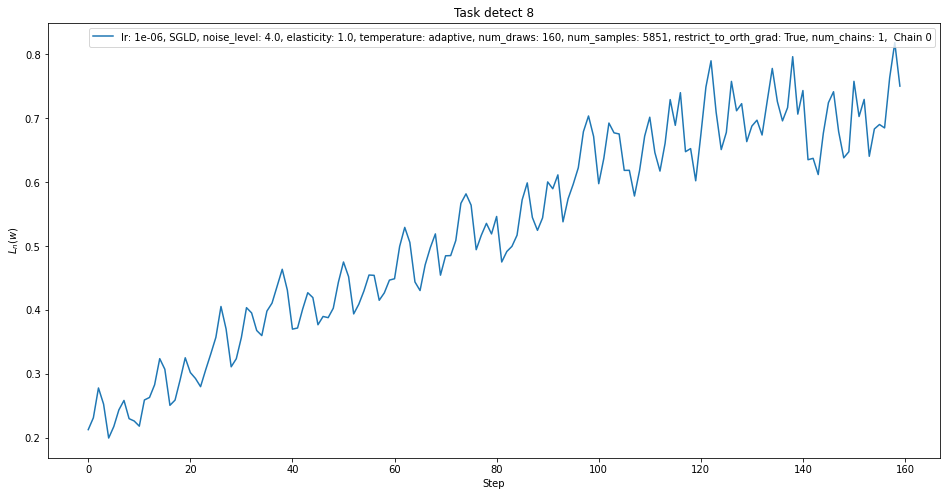

In [7]:
from devinterp.slt.rlct_tune_utils import *
# sweep over hyperparams, storing rlct estimate summary
loader = task1_train_loader
hyperparams = {
    "lr_list": [1e-6],
    "restrict_to_orth_grad_list": [True],
    "optimizer_list": [SGLD],
    "num_samples": [len(loader.dataset)],

    # SGNHT
    "diffusion_factor_list": [0.01, 0.05],

    # SGLD
    "noise_level_list": [4.0],
    "elasticity_list": [1.0],
    "temperature_list": ['adaptive'],

    # chain config
    "num_draws": [160],
    "num_chains": [1],
}


# run parallel jobs
args_list = make_args_list(**hyperparams)
# print(args_list)
# rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
#     delayed(get_summary_for_hyperparams)(copy.deepcopy(model), args) 
#     for args in args_list)
rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
    delayed(get_summary_for_hyperparams)(copy.deepcopy(model), args, loader=loader) 
    for args in args_list)
# print(args_list)
plot_chains(hyperparams, rlct_estimate_summary_list, task_name=task1_str)

In [8]:
task1_summaries = rlct_estimate_summary_list

Task 2

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


lr: 1e-07, SGLD, noise_level: 3.0, elasticity: 10.0, temperature: adaptive, num_draws: 300, num_samples: 5958, restrict_to_orth_grad: True, num_chains: 1, 


[Parallel(n_jobs=8)]: Done   1 tasks      | elapsed:    5.1s


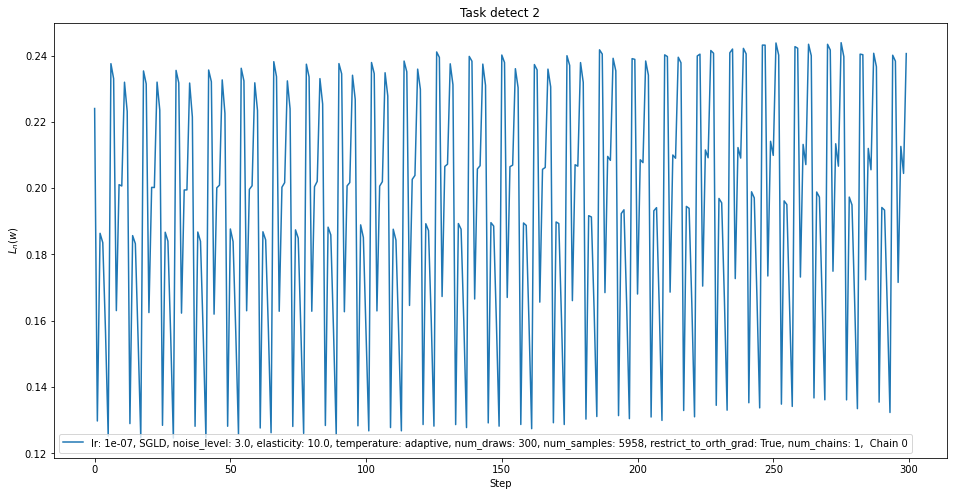

In [9]:
from devinterp.slt.rlct_tune_utils import *
# sweep over hyperparams, storing rlct estimate summary
loader = task2_train_loader
hyperparams = {
    "lr_list": [1e-7],
    "restrict_to_orth_grad_list": [True],
    "optimizer_list": [SGLD],
    "num_samples": [len(loader.dataset)],

    # SGNHT
    "diffusion_factor_list": [0.1],

    # SGLD
    "noise_level_list": [3.0],
    "elasticity_list": [10.0],
    "temperature_list": ['adaptive'],

    # chain config
    "num_draws": [300],
    "num_chains": [1],
}


# run parallel jobs
args_list = make_args_list(**hyperparams)
# print(args_list)
# rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
#     delayed(get_summary_for_hyperparams)(copy.deepcopy(model), args) 
#     for args in args_list)
rlct_estimate_summary_list = Parallel(n_jobs=8, verbose=10)(
    delayed(get_summary_for_hyperparams)(copy.deepcopy(model), args, loader=loader) 
    for args in args_list)
# print(args_list)
plot_chains(hyperparams, rlct_estimate_summary_list, task_name=task2_str)

In [10]:
task2_summaries = rlct_estimate_summary_list

In [11]:
# compare task 1 and task 2 rlct summary
print(task1_summaries[0]['mean'], task2_summaries[0]['mean'])

209.06463623046875 -20.883852005004883


### After changing the criterion to two labels only